<a href="https://colab.research.google.com/github/IT21238994/24-25J-169-iTranz/blob/RouteModel_IT21298394/Route_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installation and import libraries**

In [2]:
!pip install lightgbm shap imbalanced-learn
!pip install dask[dataframe]

import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


### **Import dataset & explore**

In [4]:
from google.colab import files
uploaded = files.upload()

# Adjust the file path/name as needed
file_path = 'bus_schedule_sept_dec_2024.csv'
df = pd.read_csv(file_path)

print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())


Saving bus_schedule_sept_dec_2024.csv to bus_schedule_sept_dec_2024.csv
First 5 rows of the dataset:
         Date     Day      Time  Route Starting_Point  Ending_Point  \
0  01.09.2024  Sunday  07:00 AM    138        Kottawa  Colombo Fort   
1  01.09.2024  Sunday  07:00 AM    138   Colombo Fort       Kottawa   
2  01.09.2024  Sunday  07:35 AM    138        Kottawa  Colombo Fort   
3  01.09.2024  Sunday  07:35 AM    138   Colombo Fort       Kottawa   
4  01.09.2024  Sunday  08:10 AM    138        Kottawa  Colombo Fort   

  Traffic_Level  Delay (min)   Status  Distance (km)  Full Trip Time(min)  \
0           Low          0.0  On Time           20.5                   90   
1           Low          0.0  On Time           19.8                   94   
2           Low          0.0  On Time           19.4                   94   
3           Low          1.0  Delayed           20.2                   93   
4           Low          3.0  Delayed           19.6                   92   

   Averag

### **Data preprocessing & cleaning**

In [5]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Convert certain columns to string type if they are categorical
for col in [
    'Day', 'Route', 'Starting_Point', 'Ending_Point',
    'Traffic_Level', 'Status'
]:
    df[col] = df[col].astype(str)

# Example: If your data has a "Cancelled" status, you might exclude or handle it differently.
# For now, we keep all statuses as potential features.

# Initialize LabelEncoders for each categorical column
le_day = LabelEncoder()
le_route = LabelEncoder()
le_start = LabelEncoder()
le_end = LabelEncoder()
le_traffic = LabelEncoder()
le_status = LabelEncoder()

# Fit-transform each column
df['Day_Encoded'] = le_day.fit_transform(df['Day'])
df['Route_Encoded'] = le_route.fit_transform(df['Route'])
df['Starting_Encoded'] = le_start.fit_transform(df['Starting_Point'])
df['Ending_Encoded'] = le_end.fit_transform(df['Ending_Point'])
df['Traffic_Level_Encoded'] = le_traffic.fit_transform(df['Traffic_Level'])
df['Status_Encoded'] = le_status.fit_transform(df['Status'])


Missing Values in Each Column:
Date                             0
Day                              0
Time                             0
Route                            0
Starting_Point                   0
Ending_Point                     0
Traffic_Level                    0
Delay (min)                    482
Status                           0
Distance (km)                    0
Full Trip Time(min)              0
Average Speed (kmph)             0
Average Bus Stop Time(min)       0
Fare (LKR)                       0
Seat_Availability (%)            0
Historical_Peak_Delay (min)      0
dtype: int64


In [7]:
# Identify columns with missing values
missing_columns = ['Delay (min)'] #, 'Delay_Fare_Interaction', 'Delay_Squared'

# Fill each missing column with its median
for col in missing_columns:
    df[col] = df[col].fillna(df[col].median())

# Confirm that no NaNs remain in those columns
print("\nMissing Values After Median Imputation:")
print(df[missing_columns].isnull().sum())



Missing Values After Median Imputation:
Delay (min)    0
dtype: int64


In [8]:
def extract_time_features(time_str):
    try:
        time_obj = pd.to_datetime(time_str, format='%I:%M %p')
        return time_obj.hour, time_obj.minute
    except:
        return 12, 0  # fallback if parsing fails

df[['Hour', 'Minute']] = df['Time'].apply(lambda x: pd.Series(extract_time_features(x)))

# Cyclical encoding of hour & minute
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute_Sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_Cos'] = np.cos(2 * np.pi * df['Minute'] / 60)


print("\nTemporal features extracted and cyclic representations created.")

# Example interaction features
df['Delay_Fare_Interaction'] = df['Delay (min)'] * df['Fare (LKR)']
df['Seat_Fare_Interaction'] = df['Seat_Availability (%)'] * df['Fare (LKR)']

# Non-linear transformations
df['Delay_Squared'] = df['Delay (min)'] ** 2
df['Fare_Log'] = np.log1p(df['Fare (LKR)'])

print("\nNon-linear features created.")


Temporal features extracted and cyclic representations created.

Non-linear features created.


Define the best_route correctly

In [9]:
# Convert 'Date' to datetime format and create 'Date_dt'
df['Date_dt'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
print("\n'Date_dt' column created from 'Date'.")

# Check if 'User_ID' exists; if not, create it based on 'Date_dt' and 'Time'
if 'User_ID' not in df.columns:
    # Create a synthetic 'User_Journey' by combining 'Date_dt' and 'Time'
    df['User_Journey'] = df['Date_dt'].astype(str) + "_" + df['Time']

    # Encode 'User_Journey' as numeric 'User_ID'
    le_journey = LabelEncoder()
    df['User_ID'] = le_journey.fit_transform(df['User_Journey'])

    print("\nSynthetic 'User_Journey' and 'User_ID' columns created based on 'Date_dt' and 'Time'.")
else:
    print("\n'User_ID' column already exists.")


'Date_dt' column created from 'Date'.

Synthetic 'User_Journey' and 'User_ID' columns created based on 'Date_dt' and 'Time'.


Verify Group Sizes

In [10]:
# Check the number of routes per group (Date_dt, Time, User_ID)
group_sizes = df.groupby(['Date_dt', 'Time', 'User_ID']).size()
print("\nNumber of routes per group:")
print(group_sizes.value_counts())

# Display how many groups have multiple routes
num_groups_multiple_routes = (group_sizes > 1).sum()
print(f"\nNumber of groups with multiple routes: {num_groups_multiple_routes}")

# If num_groups_multiple_routes == 0, it means each group has only one route
if num_groups_multiple_routes == 0:
    print("\nAll groups have only one route. Adjusting grouping strategy.")

    # Alternative grouping: Group by 'Date_dt' and 'Hour' to allow multiple routes within the same hour
    group_sizes_new = df.groupby(['Date_dt', 'Hour']).size()
    print("\nNumber of routes per new group (Date_dt, Hour):")
    print(group_sizes_new.value_counts())

    # Check how many new groups have multiple routes
    num_groups_multiple_routes_new = (group_sizes_new > 1).sum()
    print(f"\nNumber of new groups with multiple routes: {num_groups_multiple_routes_new}")

    if num_groups_multiple_routes_new == 0:
        print("\nNo groups have multiple routes even after adjusting grouping. The dataset may not contain multiple routes per hour.")
    else:
        print("\nProceeding with new grouping (Date_dt, Hour).")
else:
    print("\nProceeding with original grouping (Date_dt, Time, User_ID).")


Number of routes per group:
2    4722
4    1030
6     122
Name: count, dtype: int64

Number of groups with multiple routes: 5874

Proceeding with original grouping (Date_dt, Time, User_ID).


### **Define 'Best_Route' Based on New Grouping**

In [11]:
# Example weighting for a composite score
weight_delay = -0.4   # negative => less delay is better
weight_fare = -0.3    # negative => cheaper is better
weight_seat = 0.3     # positive => more seats available is better

df['Route_Score'] = (weight_delay * df['Delay (min)'] +
                     weight_fare * df['Fare (LKR)'] +
                     weight_seat  * df['Seat_Availability (%)'])

# Normalize the score
df['Route_Score_Normalized'] = (
    df['Route_Score'] - df['Route_Score'].min()
) / (df['Route_Score'].max() - df['Route_Score'].min())

# Group by date and hour, then pick the highest score as “Best_Route”
df['Best_Route'] = df.groupby(['Date_dt', 'Hour'])['Route_Score_Normalized']\
                     .transform(lambda x: (x == x.max()).astype(int))

print("\nClass Distribution for 'Best_Route':")
print(df['Best_Route'].value_counts())


Class Distribution for 'Best_Route':
Best_Route
0    12481
1     1815
Name: count, dtype: int64


Verify 'Best_Route' Creation

In [12]:
# Display the first few rows to verify 'Best_Route'
print("\nSample 'Best_Route' values:")
print(df[['Date_dt', 'Hour', 'Route', 'Route_Score_Normalized', 'Best_Route']].head(10))

# Check if any group has zero Best_Route
group_counts = df.groupby(['Date_dt', 'Hour'])['Best_Route'].sum()
zero_best_routes = (group_counts == 0).sum()
print(f'\nNumber of groups with zero Best_Route: {zero_best_routes}')

# If any groups have zero Best_Route, handle them by assigning the first route as best
if zero_best_routes > 0:
    print(f"\nHandling {zero_best_routes} groups with zero Best_Route.")
    df.loc[df.groupby(['Date_dt', 'Hour'])['Best_Route'].transform('sum') == 0, 'Best_Route'] = 1
    print("Assigned 'Best_Route' as 1 for these groups.")

# Re-check class distribution
print("\nClass Distribution for 'Best_Route':")
print(df['Best_Route'].value_counts())

# Plot class distribution
# sns.countplot(df['Best_Route'])
# plt.title('Class Distribution for Best_Route')
# plt.xlabel('Best_Route')
# plt.ylabel('Count')
# plt.show()


Sample 'Best_Route' values:
     Date_dt  Hour Route  Route_Score_Normalized  Best_Route
0 2024-09-01     7   138                0.619946           0
1 2024-09-01     7   138                0.684636           0
2 2024-09-01     7   138                0.757412           0
3 2024-09-01     7   138                0.649596           0
4 2024-09-01     8   138                0.579515           0
5 2024-09-01     8   138                0.676550           0
6 2024-09-01     8   138                0.595687           0
7 2024-09-01     8   138                0.622642           0
8 2024-09-01     9   138                0.692722           0
9 2024-09-01     9   138                0.644205           0

Number of groups with zero Best_Route: 0

Class Distribution for 'Best_Route':
Best_Route
0    12481
1     1815
Name: count, dtype: int64


Feature Selection and Model Preparation

In [13]:
feature_cols = [
    # Encoded categorical features
    'Day_Encoded', 'Route_Encoded', 'Starting_Encoded', 'Ending_Encoded',
    'Traffic_Level_Encoded', 'Status_Encoded',
    # Time features
    'Hour_Sin', 'Hour_Cos', 'Minute_Sin', 'Minute_Cos',
    # Original numerical columns
    'Delay (min)', 'Distance (km)', 'Full Trip Time(min)',
    'Average Speed (kmph)', 'Average Bus Stop Time(min)', 'Fare (LKR)',
    'Seat_Availability (%)', 'Historical_Peak_Delay (min)', 'Hour',
    # Interaction / Non-linear
    'Delay_Fare_Interaction', 'Seat_Fare_Interaction', 'Delay_Squared', 'Fare_Log'
]

X = df[feature_cols]
y = df['Best_Route']  # or define your own target if you have a different approach

print("\nFeature columns and target variable defined.")

scaler = StandardScaler()
numerical_features = [
    'Delay (min)', 'Distance (km)', 'Full Trip Time(min)',
    'Average Speed (kmph)', 'Average Bus Stop Time(min)', 'Fare (LKR)',
    'Seat_Availability (%)', 'Historical_Peak_Delay (min)',
    'Delay_Fare_Interaction', 'Seat_Fare_Interaction',
    'Delay_Squared', 'Fare_Log'
]
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nFeature scaling applied to numerical features.")


Feature columns and target variable defined.

Feature scaling applied to numerical features.


### **Split the Data into Training and Testing Sets**

In [14]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")



Data split into training and testing sets.
Training set size: 11436 samples
Testing set size: 2860 samples


In [15]:
######### Handle Class Imbalance with SMOTE


# Check class distribution in the training set
print("\nClass Distribution in Training Set Before SMOTE:")
print(y_train.value_counts())

# # Plot class distribution
# sns.countplot(y_train)
# plt.title('Class Distribution in Training Set Before SMOTE')
# plt.xlabel('Best_Route')
# plt.ylabel('Count')
# plt.show()


Class Distribution in Training Set Before SMOTE:
Best_Route
0    9984
1    1452
Name: count, dtype: int64


In [16]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())

# # Plot the new class distribution
# sns.countplot(y_train_res)
# plt.title('Class Distribution After SMOTE')
# plt.xlabel('Best_Route')
# plt.ylabel('Count')
# plt.show()


Class Distribution After SMOTE:
Best_Route
0    9984
1    9984
Name: count, dtype: int64


### **Train the LightGBM Model**

In [17]:
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data = lgb.Dataset(X_train_res, label=y_train_res)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data]
)


### **Model Evaluation**

In [18]:
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_mat = confusion_matrix(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(class_rep)



Accuracy: 0.9206
ROC-AUC: 0.9526

Confusion Matrix:
[[2395  102]
 [ 125  238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2497
           1       0.70      0.66      0.68       363

    accuracy                           0.92      2860
   macro avg       0.83      0.81      0.82      2860
weighted avg       0.92      0.92      0.92      2860



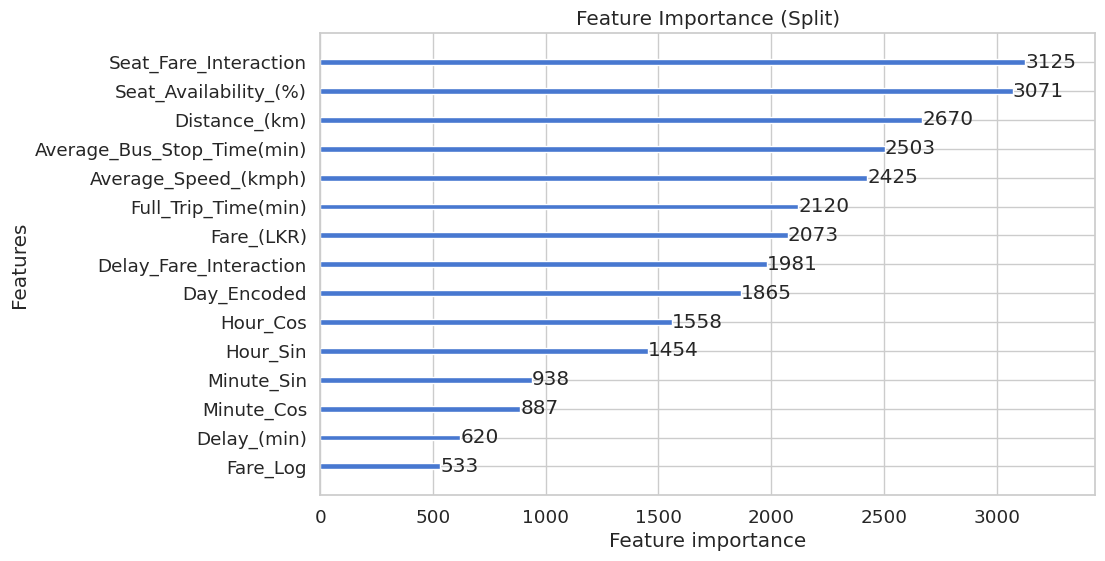

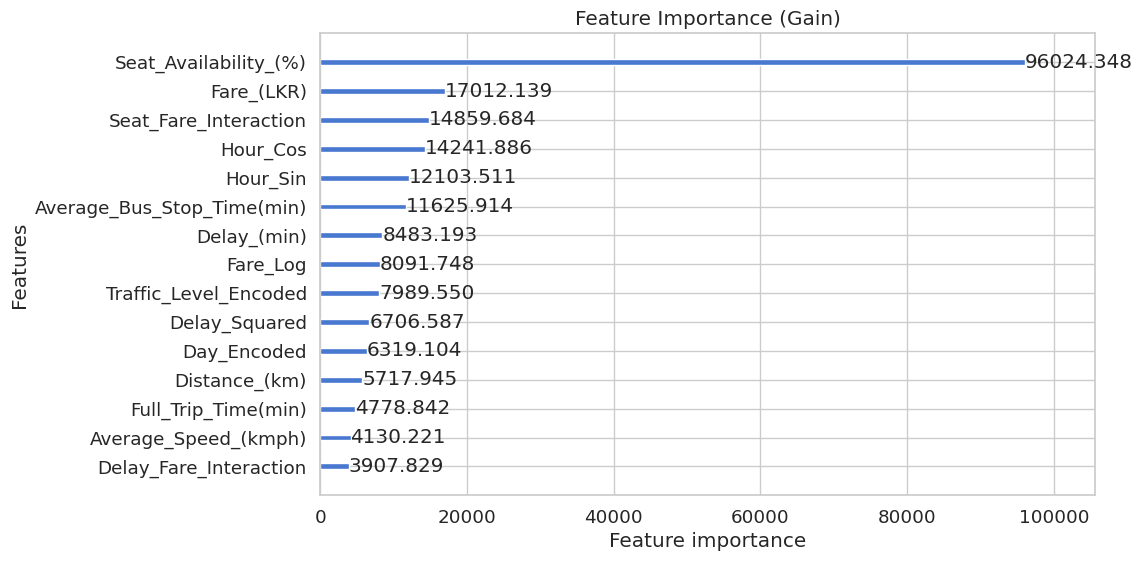

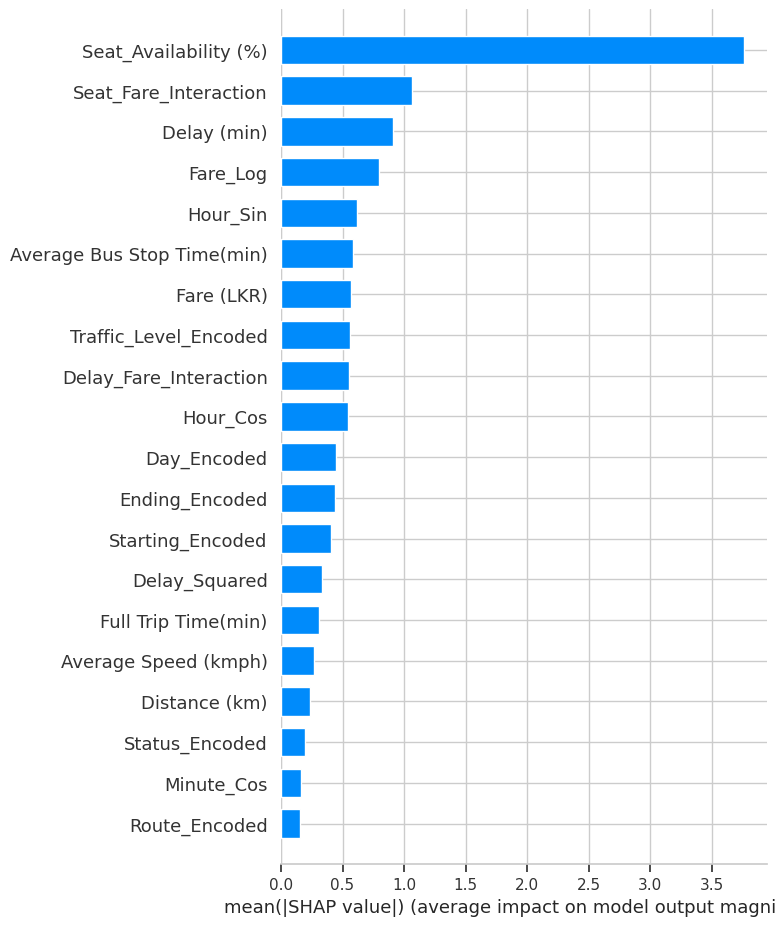

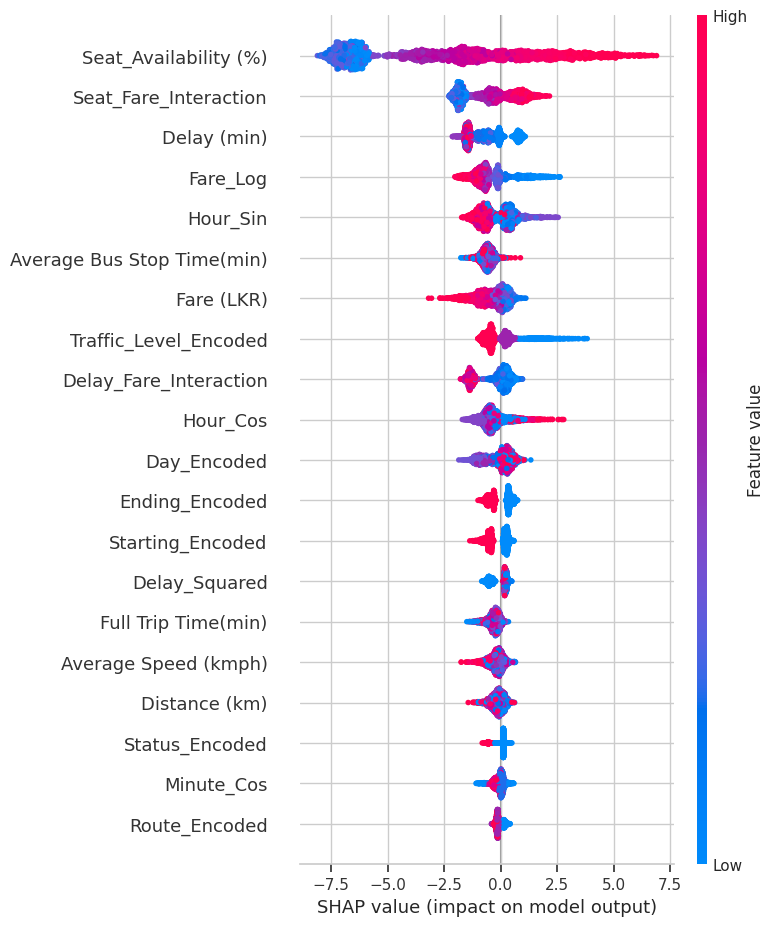

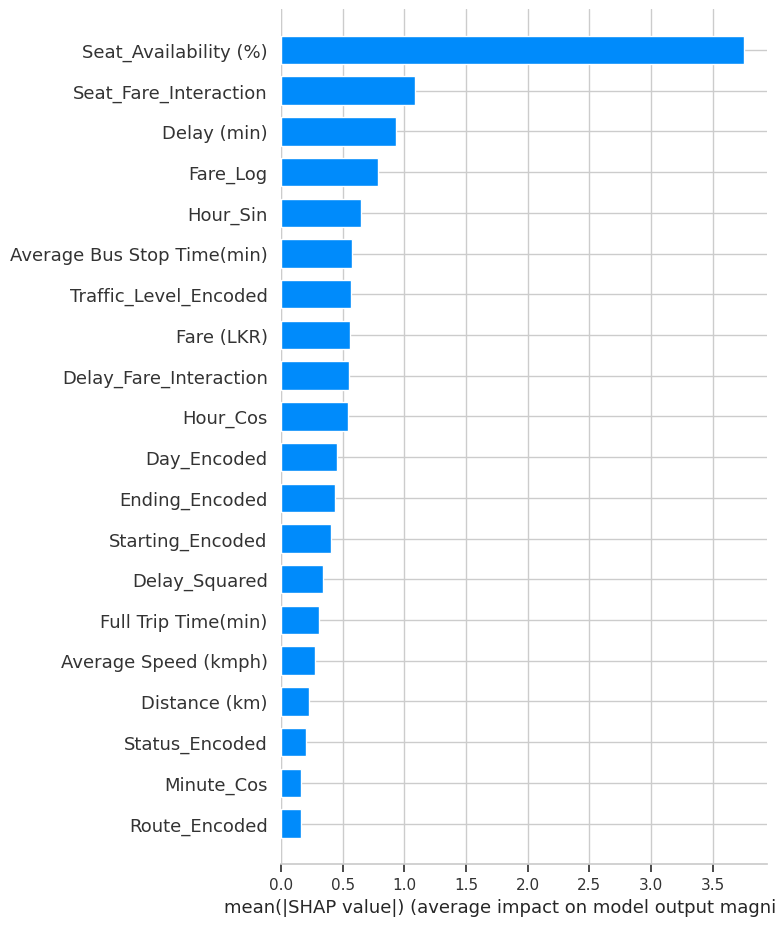

In [19]:
############# Feature Importance and SHAP Analysis


# Feature importance based on split
lgb.plot_importance(gbm, max_num_features=15, importance_type='split', figsize=(10,6))
plt.title('Feature Importance (Split)')
plt.show()

# Feature importance based on gain
lgb.plot_importance(gbm, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title('Feature Importance (Gain)')
plt.show()

# SHAP Analysis
# Initialize SHAP explainer
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP Summary Plot (Dot)
shap.summary_plot(shap_values, X_test)

# If performance is an issue, sample a subset
sample_indices = np.random.choice(X_test.index, size=500, replace=False)
shap_values_sample = explainer.shap_values(X_test.loc[sample_indices])

# SHAP Summary Plot for the sample
shap.summary_plot(shap_values_sample, X_test.loc[sample_indices], plot_type="bar")

In [20]:
##############################
##  Save the Trained Model  ##
##############################


# Save the LightGBM model to a file
gbm.save_model('lightgbm_best_bus_route_model.txt')
print("\nLightGBM model saved as 'lightgbm_best_bus_route_model.txt'.")

# To load the model later:
# gbm_loaded = lgb.Booster(model_file='lightgbm_best_bus_route_model.txt')
# sample = X_test.iloc[:5]
# sample_pred_prob = gbm_loaded.predict(sample, num_iteration=gbm_loaded.best_iteration)
# print(sample_pred_prob)


LightGBM model saved as 'lightgbm_best_bus_route_model.txt'.
